In [2]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [9]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dropout, BatchNormalization

In [4]:
#Function to load and iterate through images for each patient_id and assign the correct label, 0 or 1, for the image
def load_images(path):
    data = [] #store images
    labels = [] #store labels: 0 or 1
    
    #iterate through each patient_id folder
    for patient_id in os.listdir(path):
        patient_path = os.path.join(path, patient_id)
        
        #if patient_path is a directory
        if os.path.isdir(patient_path):
            #iterate through each sub-folder (0 and 1)
            for label in ['0', '1']:
                img_folder_path = os.path.join(patient_path, label)
                
                #if the sub-folder exists
                if os.path.exists(img_folder_path):
                    #iterate through each image
                    for img_name in os.listdir(img_folder_path):
                        img_path = os.path.join(img_folder_path, img_name)
                        
                        try:
                            img = Image.open(img_path).convert('RGB') #open image and convert to RGB
                            img = img.resize((50, 50), Image.ANTIALIAS) #resize image to 50x50 for consistency
                            img = np.array(img) #convert image to numpy array
                            
                            #append image data and label to appropriate list
                            data.append(img)
                            labels.append(int(label))
                        except Exception as e: #error loading this image
                            print(f"Error loading {img_path}: {e}")
    
    #convert lists to numpy arrays
    data = np.stack(data) #np.stack guarantees a 4D array
    labels = np.array(labels)
    
    return data, labels

In [5]:
path = 'IDC_data'

#load images and labels
data, labels = load_images(path)

#check shape of loaded data and labels
print(data.shape, labels.shape)

(277524, 50, 50, 3) (277524,)


In [9]:
#Save load_images(path) results to a file in my current working directory for quicker access for future Jupyter sessions
with open('data_and_labels.pkl', 'wb') as f:
    pickle.dump((data, labels), f)

In [4]:
#JUST RUN THIS: Access saved load_images(path) results
with open('data_and_labels.pkl', 'rb') as f:
    data, labels = pickle.load(f)

In [5]:
#Separate non-IDC and IDC images
non_IDC_images = data[labels == 0]
IDC_images = data[labels == 1]

print("Non-IDC images shape:", non_IDC_images.shape)
print("IDC images shape:", IDC_images.shape)

Non-IDC images shape: (198738, 50, 50, 3)
IDC images shape: (78786, 50, 50, 3)


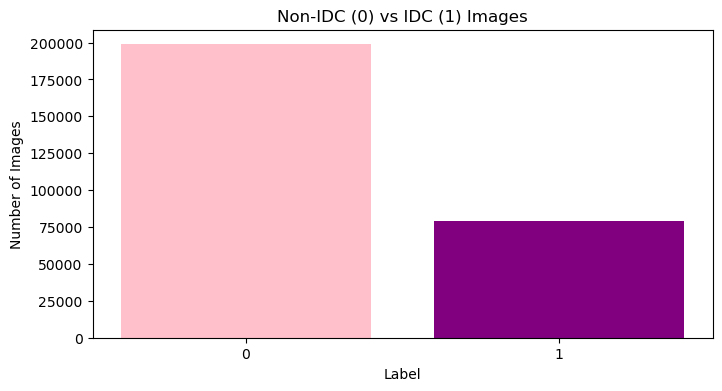

In [29]:
#Display distribution of non-IDC and IDC images to show the imbalance
non_IDC_count = non_IDC_images.shape[0]
IDC_count = IDC_images.shape[0]

plt.figure(figsize=(8, 4))
plt.bar(['0', '1'], [non_IDC_count, IDC_count], color=['pink', 'purple'])

plt.title('Non-IDC (0) vs IDC (1) Images')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.show()

In [6]:
#Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    labels,
                                                    test_size=0.2, #80% is training, 20% is testing
                                                    stratify=labels)

#Split training set into a new training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.25, #0.25*0.8=0.2 -> 20% of original dataset is for validation
                                                  stratify=y_train)

print("X_train shape:", X_train.shape) #60% of all data
print("y_train shape:", y_train.shape)

print("X_val shape:", X_val.shape) #20% of all data
print("y_val shape:", y_val.shape)

print("X_test shape:", X_test.shape) #20% of all data
print("y_test shape:", y_test.shape)

X_train shape: (166514, 50, 50, 3)
y_train shape: (166514,)
X_val shape: (55505, 50, 50, 3)
y_val shape: (55505,)
X_test shape: (55505, 50, 50, 3)
y_test shape: (55505,)


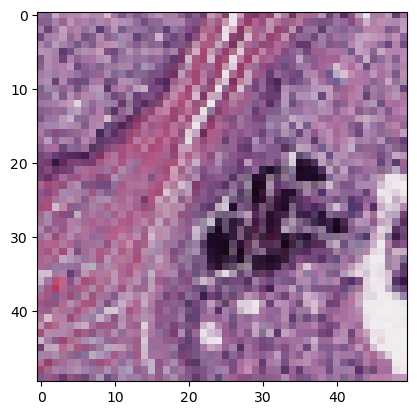

In [26]:
#Display some images
image = X_train[13000]
plt.imshow(image)

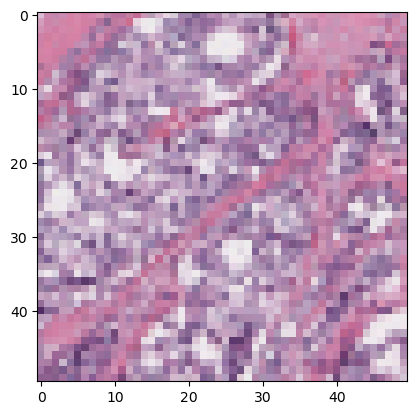

In [20]:
image = X_train[467]
plt.imshow(image)

In [27]:
class_names = {0: 'No IDC', 1: 'IDC'}

for label in y_train[:10]:
    print(class_names[label])

No IDC
IDC
No IDC
No IDC
IDC
IDC
IDC
No IDC
No IDC
IDC


0


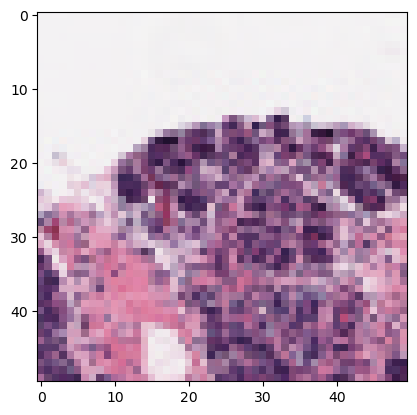

In [28]:
index = 0
print(y_train[index])
plt.imshow(X_train[index])

#0 indicates that IDC is not present

1


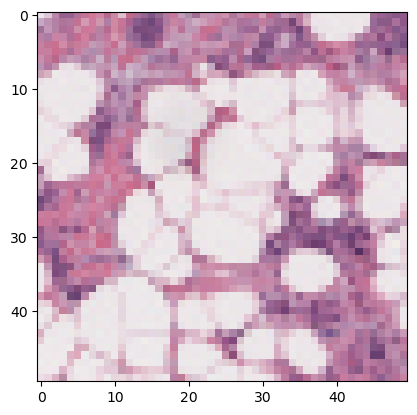

In [33]:
index = 9
print(y_train[index])
plt.imshow(X_train[index])

#1 indicates that IDC is present

## Convolutional Neural Network (CNN) model:

In [13]:
#MODEL 1
#Train model using training set and validation set with cross-validation

kf = KFold(n_splits=5, shuffle=True, random_state=42) #5-fold cross validation
fold_num = 1
acc_per_fold = [] #holds accuracy for each fold
f1_per_fold = []
precision_per_fold = []
recall_per_fold = []

for train_index, val_index in kf.split(X_train):
    K.clear_session()
    
    #Incorporate early stopping so that model stops training when it's no longer improving
    early_stopping = EarlyStopping(
        monitor='val_recall', #metric to monitor
        patience=2, #number of epochs with no improvement before stopping
        restore_best_weights=True #restores model weights from the epoch with the best f1-score
    )
    
    X_train_fold = X_train[train_index]
    X_val_fold = X_train[val_index]
    y_train_fold = y_train[train_index]
    y_val_fold = y_train[val_index]

    #create the CNN model
    model1 = Sequential([Conv2D(32, (3,3), activation='relu', input_shape=(50,50,3)),
                     MaxPooling2D((2,2)),
                    Conv2D(64, (3,3), activation='relu'),
                     MaxPooling2D((2,2)),
                    Flatten(),
                    Dense(64, activation='relu'),
                    Dense(1, activation='sigmoid')])
    
    #compile model
    model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(), Recall()])
    
    #train model
    model1.fit(X_train_fold,
               y_train_fold,
               validation_data=(X_val_fold, y_val_fold),
               epochs=1,
               batch_size=32,
               callbacks=[early_stopping])
    
    #get predictions
    y_pred_probs = model1.predict(X_val_fold)
    y_pred = (y_pred_probs > 0.5).astype('int32').flatten() #convert probabilities to 0 or 1

    #evaluate model on the validation fold -> get f1, precision, recall, and accuracy
    precision = precision_score(y_val_fold, y_pred, average='binary')
    recall = recall_score(y_val_fold, y_pred, average='binary')
    f1 = f1_score(y_val_fold, y_pred)

    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)
    
    print(f"\nPrecision for fold {fold_num}: {precision:.2f}")
    print(f"\nRecall for fold {fold_num}: {recall:.2f}")
    print(f"\nF1-score for fold {fold_num}: {f1:.2f}")

    scores = model1.evaluate(X_val_fold, y_val_fold)
    acc_per_fold.append(scores[1])
    print(f"Accuracy for fold {fold_num}: {scores[1]:.2f}\n")

    fold_num += 1

#averaging the evaluation metrics for all folds
print(f"\nAverage Precision for all folds: {np.mean(precision_per_fold):.2f}")
print(f"Average Recall for all folds: {np.mean(recall_per_fold):.2f}")
print(f"Average F1-score for all folds: {np.mean(f1_per_fold):.2f}")
print(f"Average Accuracy for all folds: {np.mean(acc_per_fold):.2f}\n")

1041/1041 [==============================] - 14s 13ms/step

Precision for fold 1: 0.82

Recall for fold 1: 0.42

F1-score for fold 1: 0.55
1041/1041 [==============================] - 14s 13ms/step - loss: 0.4067 - precision: 0.8167 - recall: 0.4163
Accuracy for fold 1: 0.82

1041/1041 [==============================] - 14s 14ms/step

Precision for fold 2: 0.00

Recall for fold 2: 0.00

F1-score for fold 2: 0.00
1041/1041 [==============================] - 14s 14ms/step - loss: 0.5888 - precision: 0.0000e+00 - recall: 0.0000e+00
Accuracy for fold 2: 0.00

1041/1041 [==============================] - 14s 13ms/step

Precision for fold 3: 0.76

Recall for fold 3: 0.51

F1-score for fold 3: 0.61
1041/1041 [==============================] - 15s 14ms/step - loss: 0.4060 - precision: 0.7606 - recall: 0.5093
Accuracy for fold 3: 0.76

1041/1041 [==============================] - 13s 13ms/step

Precision for fold 4: 0.73

Recall for fold 4: 0.61

F1-score for fold 4: 0.67
1041/1041 [===========

In [16]:
#MODEL 2
#Try a different CNN model with different hyperparameters and layers

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_num = 1
acc_per_fold = []
f1_per_fold = []
precision_per_fold = []
recall_per_fold = []

for train_index, val_index in kf.split(X_train):
    K.clear_session()
    
    early_stopping = EarlyStopping(
        monitor='val_recall',
        patience=2,
        restore_best_weights=True
    )
    
    X_train_fold = X_train[train_index]
    X_val_fold = X_train[val_index]
    y_train_fold = y_train[train_index]
    y_val_fold = y_train[val_index]

    #create the new CNN model
    model2 = Sequential([Conv2D(32, (3,3), activation='relu', input_shape=(50,50,3)),
                    BatchNormalization(),
                    MaxPooling2D((2,2)),
                    Dropout(0.25),
                         
                    Conv2D(64, (3,3), activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D((2,2)),
                    Dropout(0.25),
                         
                    Flatten(),
                    Dense(64, activation='relu'),
                    BatchNormalization(),
                    Dense(1, activation='sigmoid')])
    
    #compile model
    model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(), Recall()])
    
    #train model
    model2.fit(X_train_fold,
               y_train_fold,
               validation_data=(X_val_fold, y_val_fold),
               epochs=1,
               batch_size=32,
               callbacks=[early_stopping])
    
    y_pred_probs = model2.predict(X_val_fold)
    y_pred = (y_pred_probs > 0.5).astype('int32').flatten()

    precision = precision_score(y_val_fold, y_pred, average='binary')
    recall = recall_score(y_val_fold, y_pred, average='binary')
    f1 = f1_score(y_val_fold, y_pred)

    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)
    
    print(f"\nPrecision for fold {fold_num}: {precision:.4f}")
    print(f"\nRecall for fold {fold_num}: {recall:.4f}")
    print(f"\nF1-score for fold {fold_num}: {f1:.4f}")

    scores = model2.evaluate(X_val_fold, y_val_fold)
    acc_per_fold.append(scores[1])
    print(f"Accuracy for fold {fold_num}: {scores[1]:.4f}\n")

    fold_num += 1

#averaging the evaluation metrics for all folds
print(f"\nAverage Precision for all folds: {np.mean(precision_per_fold):.2f}")
print(f"Average Recall for all folds: {np.mean(recall_per_fold):.2f}")
print(f"Average F1-score for all folds: {np.mean(f1_per_fold):.2f}")
print(f"Average Accuracy for all folds: {np.mean(acc_per_fold):.2f}\n")

1041/1041 [==============================] - 16s 15ms/step

Precision for fold 1: 0.4563

Recall for fold 1: 0.8217

F1-score for fold 1: 0.5868
1041/1041 [==============================] - 15s 15ms/step - loss: 0.5977 - precision: 0.4563 - recall: 0.8217
Accuracy for fold 1: 0.4563

1041/1041 [==============================] - 16s 15ms/step

Precision for fold 2: 0.7889

Recall for fold 2: 0.6101

F1-score for fold 2: 0.6881
1041/1041 [==============================] - 16s 15ms/step - loss: 0.3910 - precision: 0.7889 - recall: 0.6101
Accuracy for fold 2: 0.7889

1041/1041 [==============================] - 16s 15ms/step

Precision for fold 3: 0.8945

Recall for fold 3: 0.1511

F1-score for fold 3: 0.2586
1041/1041 [==============================] - 16s 16ms/step - loss: 0.6678 - precision: 0.8945 - recall: 0.1511
Accuracy for fold 3: 0.8945

1041/1041 [==============================] - 15s 15ms/step

Precision for fold 4: 0.7073

Recall for fold 4: 0.7046

F1-score for fold 4: 0.7059


In [20]:
#MODEL 3
#Same CNN model as MODEL 2 but with more epochs and less folds

kf = KFold(n_splits=3, shuffle=True, random_state=42) #3-fold cross validation instead of 5
fold_num = 1
acc_per_fold = []
f1_per_fold = []
precision_per_fold = []
recall_per_fold = []

for train_index, val_index in kf.split(X_train):
    K.clear_session()
    
    early_stopping = EarlyStopping(
        monitor='val_recall',
        patience=2,
        restore_best_weights=True
    )
    
    X_train_fold = X_train[train_index]
    X_val_fold = X_train[val_index]
    y_train_fold = y_train[train_index]
    y_val_fold = y_train[val_index]

    model3 = Sequential([Conv2D(32, (3,3), activation='relu', input_shape=(50,50,3)),
                    BatchNormalization(),
                    MaxPooling2D((2,2)),
                    Dropout(0.25),
                         
                    Conv2D(64, (3,3), activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D((2,2)),
                    Dropout(0.25),
                         
                    Flatten(),
                    Dense(64, activation='relu'),
                    BatchNormalization(),
                    Dense(1, activation='sigmoid')])
       
    #compile model
    model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(), Recall()])
    
    #train model with 2 epochs instead of 1
    model3.fit(X_train_fold,
               y_train_fold,
               validation_data=(X_val_fold, y_val_fold),
               epochs=2,
               batch_size=32,
               callbacks=[early_stopping])
    
    y_pred_probs = model3.predict(X_val_fold)
    y_pred = (y_pred_probs > 0.5).astype('int32').flatten()

    precision = precision_score(y_val_fold, y_pred, average='binary')
    recall = recall_score(y_val_fold, y_pred, average='binary')
    f1 = f1_score(y_val_fold, y_pred)

    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)
    
    print(f"\nPrecision for fold {fold_num}: {precision:.4f}")
    print(f"\nRecall for fold {fold_num}: {recall:.4f}")
    print(f"\nF1-score for fold {fold_num}: {f1:.4f}")

    scores = model3.evaluate(X_val_fold, y_val_fold)
    acc_per_fold.append(scores[1])
    print(f"Accuracy for fold {fold_num}: {scores[1]:.4f}\n")

    fold_num += 1

#averaging the evaluation metrics for all folds
print(f"\nAverage Precision for all folds: {np.mean(precision_per_fold):.2f}")
print(f"Average Recall for all folds: {np.mean(recall_per_fold):.2f}")
print(f"Average F1-score for all folds: {np.mean(f1_per_fold):.2f}")
print(f"Average Accuracy for all folds: {np.mean(acc_per_fold):.2f}\n")

Epoch 1/2
3470/3470 [==============================] - 138s 39ms/step - loss: 0.3625 - precision: 0.7401 - recall: 0.6903 - val_loss: 0.3776 - val_precision: 0.6684 - val_recall: 0.8363
Epoch 2/2
1735/1735 [==============================] - 13s 8ms/step

Precision for fold 1: 0.9333

Recall for fold 1: 0.0071

F1-score for fold 1: 0.0142
1735/1735 [==============================] - 15s 8ms/step - loss: 2.0318 - precision: 0.9333 - recall: 0.0071
Accuracy for fold 1: 0.9333

Epoch 1/2
3470/3470 [==============================] - 141s 40ms/step - loss: 0.3634 - precision: 0.7424 - recall: 0.6879 - val_loss: 0.9518 - val_precision: 0.7913 - val_recall: 0.3058
Epoch 2/2
1735/1735 [==============================] - 15s 9ms/step

Precision for fold 2: 0.4898

Recall for fold 2: 0.7425

F1-score for fold 2: 0.5902
1735/1735 [==============================] - 19s 11ms/step - loss: 0.5687 - precision: 0.4898 - recall: 0.7425
Accuracy for fold 2: 0.4898

Epoch 1/2
3470/3470 [====================

In [11]:
#MODEL 4
#Same CNN model as MODEL 2, but with more epochs and same amount of folds

kf = KFold(n_splits=5, shuffle=True, random_state=42) #5-fold cross validation
fold_num = 1
acc_per_fold = []
f1_per_fold = []
precision_per_fold = []
recall_per_fold = []

for train_index, val_index in kf.split(X_train):
    K.clear_session()
    
    early_stopping = EarlyStopping(
        monitor='val_recall',
        patience=2,
        restore_best_weights=True
    )
    
    X_train_fold = X_train[train_index]
    X_val_fold = X_train[val_index]
    y_train_fold = y_train[train_index]
    y_val_fold = y_train[val_index]

    model4 = Sequential([Conv2D(32, (3,3), activation='relu', input_shape=(50,50,3)),
                    BatchNormalization(),
                    MaxPooling2D((2,2)),
                    Dropout(0.25),
                         
                    Conv2D(64, (3,3), activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D((2,2)),
                    Dropout(0.25),
                         
                    Flatten(),
                    Dense(64, activation='relu'),
                    BatchNormalization(),
                    Dense(1, activation='sigmoid')])
       
    #compile model
    model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(), Recall()])
    
    #train model with 3 epochs instead of 1
    model4.fit(X_train_fold,
               y_train_fold,
               validation_data=(X_val_fold, y_val_fold),
               epochs=3,
               batch_size=32,
               callbacks=[early_stopping])
    
    y_pred_probs = model4.predict(X_val_fold)
    y_pred = (y_pred_probs > 0.5).astype('int32').flatten()

    precision = precision_score(y_val_fold, y_pred, average='binary')
    recall = recall_score(y_val_fold, y_pred, average='binary')
    f1 = f1_score(y_val_fold, y_pred)

    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)
    
    print(f"\nPrecision for fold {fold_num}: {precision:.4f}")
    print(f"\nRecall for fold {fold_num}: {recall:.4f}")
    print(f"\nF1-score for fold {fold_num}: {f1:.4f}")

    scores = model4.evaluate(X_val_fold, y_val_fold)
    acc_per_fold.append(scores[1])
    print(f"Accuracy for fold {fold_num}: {scores[1]:.4f}\n")

    fold_num += 1

#averaging the evaluation metrics for all folds
print(f"\nAverage Precision for all folds: {np.mean(precision_per_fold):.2f}")
print(f"Average Recall for all folds: {np.mean(recall_per_fold):.2f}")
print(f"Average F1-score for all folds: {np.mean(f1_per_fold):.2f}")
print(f"Average Accuracy for all folds: {np.mean(acc_per_fold):.2f}\n")

Epoch 1/3
4163/4163 [==============================] - 256s 60ms/step - loss: 0.3616 - precision: 0.7456 - recall: 0.6857 - val_loss: 0.8882 - val_precision: 0.3562 - val_recall: 0.9731
Epoch 2/3
4163/4163 [==============================] - 226s 54ms/step - loss: 0.3350 - precision: 0.7666 - recall: 0.7120 - val_loss: 0.9573 - val_precision: 0.8380 - val_recall: 0.0836
Epoch 3/3
1041/1041 [==============================] - 16s 15ms/step

Precision for fold 1: 0.4703

Recall for fold 1: 0.8066

F1-score for fold 1: 0.5942
1041/1041 [==============================] - 15s 15ms/step - loss: 0.7142 - precision: 0.4703 - recall: 0.8066
Accuracy for fold 1: 0.4703

Epoch 1/3
4163/4163 [==============================] - 237s 56ms/step - loss: 0.3630 - precision: 0.7421 - recall: 0.6905 - val_loss: 0.4348 - val_precision: 0.7685 - val_recall: 0.5774
Epoch 2/3
4163/4163 [==============================] - 205s 49ms/step - loss: 0.3380 - precision: 0.7623 - recall: 0.7122 - val_loss: 0.6004 - val_

In [12]:
#MODEL 5
#Same CNN model as MODEL 4, but with even more epochs and a higher patience value

kf = KFold(n_splits=5, shuffle=True, random_state=42) #5-fold cross validation
fold_num = 1
acc_per_fold = []
f1_per_fold = []
precision_per_fold = []
recall_per_fold = []

for train_index, val_index in kf.split(X_train):
    K.clear_session()
    
    early_stopping = EarlyStopping(
        monitor='val_recall',
        patience=3, #3 instead of 2, since we have more epochs now
        restore_best_weights=True
    )
    
    X_train_fold = X_train[train_index]
    X_val_fold = X_train[val_index]
    y_train_fold = y_train[train_index]
    y_val_fold = y_train[val_index]

    model5 = Sequential([Conv2D(32, (3,3), activation='relu', input_shape=(50,50,3)),
                    BatchNormalization(),
                    MaxPooling2D((2,2)),
                    Dropout(0.25),
                         
                    Conv2D(64, (3,3), activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D((2,2)),
                    Dropout(0.25),
                         
                    Flatten(),
                    Dense(64, activation='relu'),
                    BatchNormalization(),
                    Dense(1, activation='sigmoid')])
       
    #compile model
    model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(), Recall()])
    
    #train model with 5 epochs instead of 3
    model5.fit(X_train_fold,
               y_train_fold,
               validation_data=(X_val_fold, y_val_fold),
               epochs=5,
               batch_size=32,
               callbacks=[early_stopping])
    
    y_pred_probs = model5.predict(X_val_fold)
    y_pred = (y_pred_probs > 0.5).astype('int32').flatten()

    precision = precision_score(y_val_fold, y_pred, average='binary')
    recall = recall_score(y_val_fold, y_pred, average='binary')
    f1 = f1_score(y_val_fold, y_pred)

    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)
    
    print(f"\nPrecision for fold {fold_num}: {precision:.4f}")
    print(f"\nRecall for fold {fold_num}: {recall:.4f}")
    print(f"\nF1-score for fold {fold_num}: {f1:.4f}")

    scores = model5.evaluate(X_val_fold, y_val_fold)
    acc_per_fold.append(scores[1])
    print(f"Accuracy for fold {fold_num}: {scores[1]:.4f}\n")

    fold_num += 1

#averaging the evaluation metrics for all folds
print(f"\nAverage Precision for all folds: {np.mean(precision_per_fold):.2f}")
print(f"Average Recall for all folds: {np.mean(recall_per_fold):.2f}")
print(f"Average F1-score for all folds: {np.mean(f1_per_fold):.2f}")
print(f"Average Accuracy for all folds: {np.mean(acc_per_fold):.2f}\n")

Epoch 1/5
4163/4163 [==============================] - 105s 25ms/step - loss: 0.3606 - precision: 0.7474 - recall: 0.6896 - val_loss: 0.4861 - val_precision: 0.7869 - val_recall: 0.2825
Epoch 2/5
4163/4163 [==============================] - 127s 30ms/step - loss: 0.3375 - precision: 0.7641 - recall: 0.7093 - val_loss: 0.4975 - val_precision: 0.8114 - val_recall: 0.5467
Epoch 3/5
4163/4163 [==============================] - 128s 31ms/step - loss: 0.3265 - precision: 0.7715 - recall: 0.7199 - val_loss: 0.3161 - val_precision: 0.7823 - val_recall: 0.7304
Epoch 4/5
1041/1041 [==============================] - 7s 7ms/step

Precision for fold 1: 0.7869

Recall for fold 1: 0.2825

F1-score for fold 1: 0.4158
1041/1041 [==============================] - 9s 9ms/step - loss: 0.4861 - precision: 0.7869 - recall: 0.2825
Accuracy for fold 1: 0.7869

Epoch 1/5
4163/4163 [==============================] - 130s 31ms/step - loss: 0.3597 - precision: 0.7450 - recall: 0.6906 - val_loss: 0.4264 - val_prec

In [15]:
#Intialize the best model from cross-validation
K.clear_session()
    
early_stopping = EarlyStopping(
    monitor='recall',
    patience=2,
    restore_best_weights=True
)
    
model = Sequential([Conv2D(32, (3,3), activation='relu', input_shape=(50,50,3)),
                    BatchNormalization(),
                    MaxPooling2D((2,2)),
                    Dropout(0.25),
                         
                    Conv2D(64, (3,3), activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D((2,2)),
                    Dropout(0.25),
                         
                    Flatten(),
                    Dense(64, activation='relu'),
                    BatchNormalization(),
                    Dense(1, activation='sigmoid')])

#Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(), Recall()])

#Train model on entire training set
model.fit(X_train, y_train, epochs=3, batch_size=32, callbacks=[early_stopping])

#Get predictions using testing set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype('int32').flatten()

#Evaluate model on testing set, images it hasn't seen yet
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred)
scores = model.evaluate(X_test, y_test)
###accuracy = accuracy_score(y_test, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'Accuracy: {scores[1]:.4f}')
##print(f'Accuracy: {accuracy:.4f}')

Epoch 1/3
5204/5204 [==============================] - 143s 27ms/step - loss: 0.3605 - precision: 0.7453 - recall: 0.6877
Epoch 2/3
5204/5204 [==============================] - 146s 28ms/step - loss: 0.3320 - precision: 0.7664 - recall: 0.7149
Epoch 3/3
1735/1735 [==============================] - 13s 8ms/step - loss: 0.7799 - precision: 0.4189 - recall: 0.7597
Precision: 0.4189
Recall: 0.7597
F1-score: 0.5400
Accuracy: 0.4189


## Final optimal model performance:

Precision: 0.4189

Recall: 0.7597

F1-Score: 0.5400

Accuracy: 0.4189

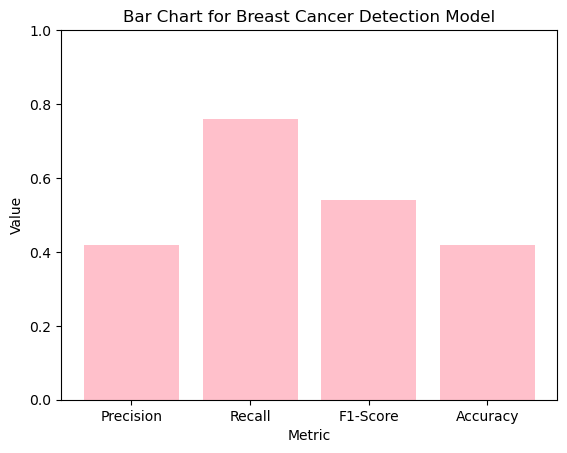

In [22]:
#Bar plot to display perfomance metrics

plt.bar(['Precision', 'Recall', 'F1-Score', 'Accuracy'], [precision, recall, f1, scores[1]], color='pink')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Bar Chart for Breast Cancer Detection Model')
plt.ylim(0, 1)
plt.show()

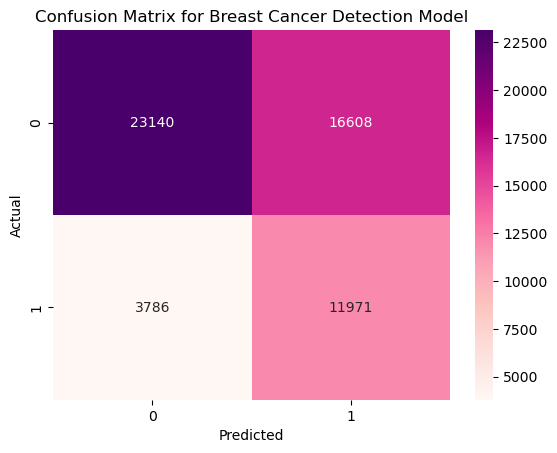

In [28]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="RdPu")
plt.title('Confusion Matrix for Breast Cancer Detection Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()